# Q4 - Recommendation and Business Analysis

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Data

In [2]:
retail_df = pd.read_csv('../Data_Q4/retail.csv')

In [3]:
retail_df.head()

,Transaction_id,Product_id,Description,Quantity,Date,Price,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009/12/1 7:45,6.95,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009/12/1 7:45,6.75,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009/12/1 7:45,2.10,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009/12/1 7:45,1.25,13085.0


In [4]:
retail_df.shape

(1048575, 7)

## 3. Data Preprocessing

In [5]:
# Check Missing values
retail_df.isnull().sum()

Transaction_id     48575
Product_id         48575
Description        52906
Quantity           48575
Date               48575
Price              48575
Customer ID       274073
dtype: int64

In [6]:
# Drop missing values
retail_df.dropna(inplace=True)

In [7]:
# Check missing values
retail_df.isnull().sum()

Transaction_id    0
Product_id        0
Description       0
Quantity          0
Date              0
Price             0
Customer ID       0
dtype: int64

In [8]:
retail_df.shape

(774502, 7)

In [9]:
# Drop duplicates
retail_df.drop_duplicates(inplace=True)

In [10]:
retail_df.shape

(749040, 7)

In [11]:
retail_df['Date'] = pd.to_datetime(retail_df['Date'])

In [12]:
# Drop Negative Values
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['Price'] > 0]

In [13]:
Q1 = retail_df['Quantity'].quantile(0.01)
Q3 = retail_df['Quantity'].quantile(0.99)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 过滤掉异常值
retail_df = retail_df[(retail_df['Quantity'] >= lower_bound) & (retail_df['Quantity'] <= upper_bound)]

# 对'Price'字段重复上述步骤
Q1_price = retail_df['Price'].quantile(0.01)
Q3_price = retail_df['Price'].quantile(0.99)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

retail_df = retail_df[(retail_df['Price'] >= lower_bound_price) & (retail_df['Price'] <= upper_bound_price)]

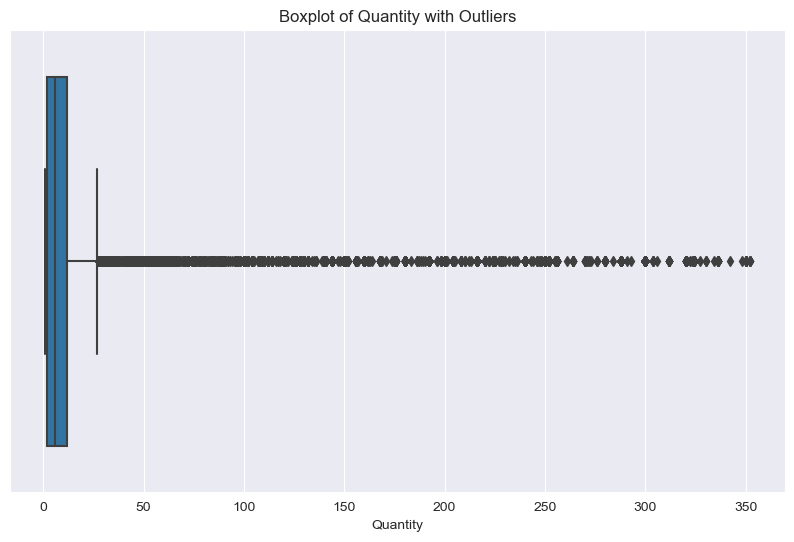

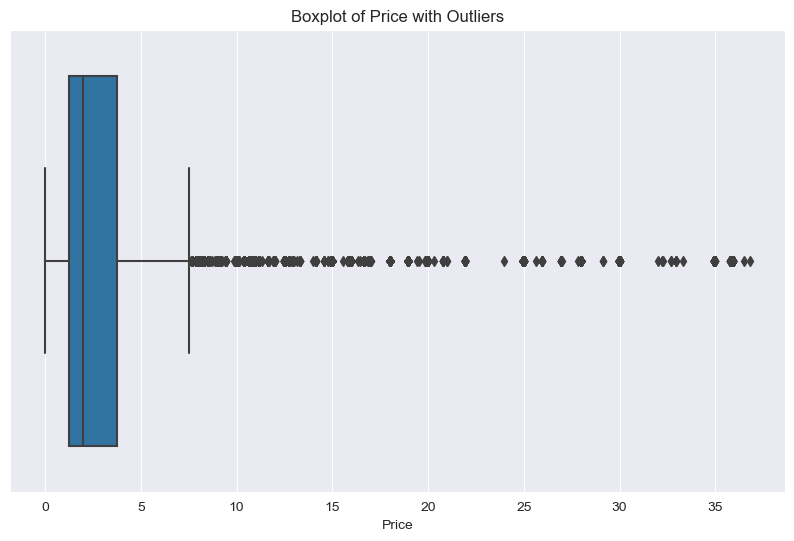

In [14]:
def plot_with_outliers(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)

    # 绘制箱形图
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dataframe[variable])
    plt.title(f'Boxplot of {variable} with Outliers')
    plt.show()

# 对'Quantity'和'Price'字段分别进行绘制
plot_with_outliers(retail_df, 'Quantity')
plot_with_outliers(retail_df, 'Price')

可视化

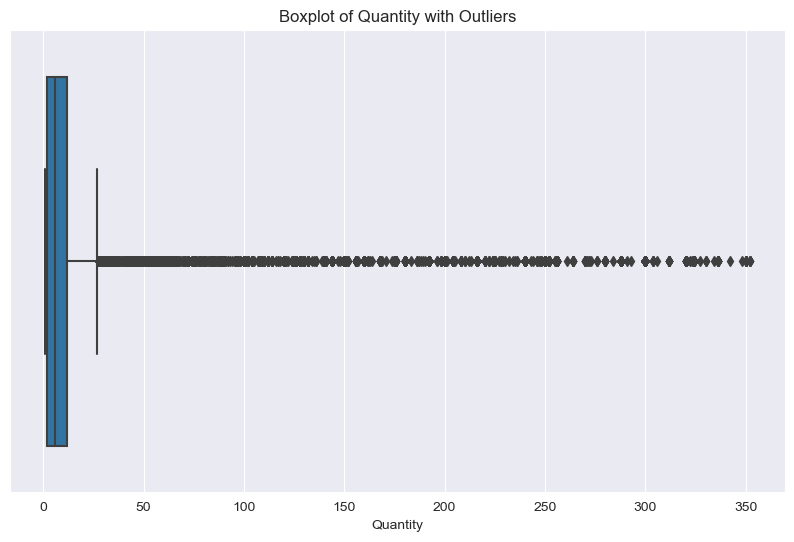

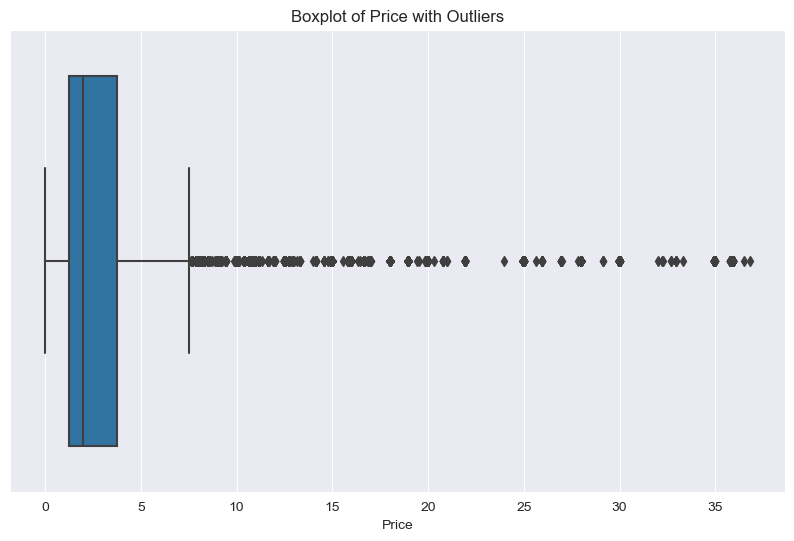

In [14]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Data Preprocessing
# Assuming each row in your DataFrame is a transaction
transactions = retail_df.groupby('Transaction_id')['Product_id'].apply(list)

# Transforming the data into the right format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [15]:
retail_df

Shape of DataFrame:  (728422, 7)
Unique Values in Each Column: 
Transaction_id    34340
Product_id         4598
Description        5242
Quantity            214
Date              32245
Price               424
Customer ID        5728
dtype: int64


,Transaction_id,Product_id,Description,Quantity,Date,Price,Customer ID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0


In [ ]:
transactions

In [ ]:
# Step 2: Finding Frequent Itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

# Step 3: Generating Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Step 4: Filtering Rules
# Filter the DataFrame of rules to find the best ones
rules = rules[(rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]

# Display top 10 rules


In [ ]:
rules

## 1. 产品销售量排行
## 1. Top 10 Products by Quantity Sold

In [ ]:
top_products = retail_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
retail_df['Month'] = retail_df['Date'].dt.to_period('M')
transactions_per_month = retail_df.groupby('Month')['Transaction_id'].nunique()
plt.figure(figsize=(12,6))
transactions_per_month.plot(kind='line')
plt.title('Number of Transactions Over Time')
plt.show()

1. 每年每个产品的总销量

In [ ]:
# 选择销量最高的前N个产品
top_products = retail_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).index

# 过滤数据，只保留这些产品
filtered_df = retail_df[retail_df['Description'].isin(top_products)]

# 重新计算销量
sales_volume_per_year = filtered_df.groupby(['Year', 'Description'])['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.barplot(x='Year', y='Quantity', hue='Description', data=sales_volume_per_year)
plt.title('Total Sales Volume per Product per Year for Top 10 Products')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


2. 客户的平均消费及其分布

In [ ]:
# 计算每位客户的平均消费
average_spending = retail_df.groupby('Customer ID')['Price'].mean().reset_index()

# 绘制分布图
plt.figure(figsize=(15, 6))
sns.distplot(average_spending['Price'])
plt.title('Average Spending per Customer')
plt.show()


3. 最受欢迎的产品

4. 不同时间段的销售趋势

In [ ]:
# 添加小时列
retail_df['Hour'] = retail_df['Date'].dt.hour

# 计算每小时的销售量
sales_per_hour = retail_df.groupby('Hour')['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.lineplot(x='Hour', y='Quantity', data=sales_per_hour)
plt.title('Sales Trend by Hour')
plt.show()


5. 不同客户群体的购买偏好

In [ ]:
# 你可以根据一些标准（如客户的总消费金额）来定义客户群体
# 例如，将消费在某个范围内的客户划分为一个群体

# 定义客户群体
customer_groups = retail_df.groupby('Customer ID')['Price'].sum()
retail_df['Customer Group'] = pd.qcut(customer_groups, 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 分析每个群体的购买偏好
preference_per_group = retail_df.groupby(['Customer Group', 'Description'])['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.barplot(x='Customer Group', y='Quantity', hue='Description', data=preference_per_group)
plt.title('Purchase Preferences by Customer Group')
plt.show()


6. 每月销售趋势
6. Sales Trend by Month

In [ ]:
# 添加月份列
retail_df['Month'] = retail_df['Date'].dt.month

# 每月的销售总量
sales_per_month = retail_df.groupby('Month')['Quantity'].sum().reset_index()

# 绘制图表
plt.figure(figsize=(15, 6))
sns.lineplot(x='Month', y='Quantity', data=sales_per_month)
plt.title('Sales Trend by Month')
plt.show()
